In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy
from sklearn.preprocessing import MinMaxScaler
import os, glob, inspect, sys
import re

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir) 
import epri_mc_lib_2 as mc
from importlib import reload
reload(mc)

<module 'epri_mc_lib_2' from '/Users/apple/Desktop/s2ds/work_project/Oct20_EPRI/Task2/NB/epri_mc_lib_2.py'>

In [131]:
from sklearn import model_selection
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt

### Import data and merge replicates

In [110]:
merged = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), '../Data/Merged_data/CopulaGAN_simulated_data.csv'),
                    index_col=None)
merged.set_index('type_cw', inplace=True)
merged

,KJIC,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,PC_IF_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,PC_IF_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,PC_BS,Type
type_cw,,,,,,,,,,,,,,,
A286-80,60.489458,0.010580,0.002000,0.002000,-1.409903,0.046787,0.002109,3.640283e+02,0.025513,2.594648,184.875799,0.018969,1.705626,-62.977927,A286
A286-80,44.261992,0.013681,0.002000,0.002000,-1.508575,0.046089,0.001903,4.615413e+02,0.022798,1.890054,901.546526,0.022046,1.504480,-64.434818,A286
A286-0,156.352240,0.014511,0.002000,0.002000,-1.220520,0.045382,0.002143,9.688812e-13,0.008521,3.973307,47.009106,0.002548,1.640369,-0.455673,A286
304-80,70.025254,4.788344,2.131362,2.820919,-1.055187,0.067237,0.002424,8.023317e+01,0.027521,3.165900,158.586692,0.024863,3.235830,-8.051534,304
304-40,102.089063,1.070462,0.821760,1.754141,-1.201403,0.052497,0.001934,4.029531e+01,0.022566,2.870203,637.420387,0.012983,5.242440,-36.263322,304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347-40,96.533556,0.338549,0.179534,0.225540,-1.261545,0.056277,0.002174,1.350067e+02,0.006515,1.112177,238.429845,0.023679,1.824403,-36.890105,347
A286-20,71.566934,0.009250,0.002000,0.002000,-1.150631,0.044825,0.002063,6.842860e+02,0.022014,1.675595,1292.052416,0.011407,0.373688,-28.171811,A286
304-80,81.170931,3.926854,2.239491,3.551210,-0.930937,0.067434,0.002443,8.748498e+01,0.023465,3.085555,139.648195,0.018672,2.814763,2.662860,304


## Select columns of interest

In [111]:
merged.drop(["Type"], axis=1, inplace=True)

## Scale data

In [112]:
# The logarithmic of the KJIC is incorporated for better results
merged.KJIC = np.log(merged.KJIC)
scaled_df = mc.scale_general(merged, MinMaxScaler())
scaled_df[0]

,KJIC,MS_Avg,MS_neg_error,MS_pos_error,TEP_average,TEP_error,Beta_avg,PC_IF_2.25MHz,SE_IF_2.25MHz,SE_%_IF_2.25MHz,PC_IF_3.5MHz,SE_IF_3.5MHz,SE_%_IF_3.5MHz,PC_BS
type_cw,,,,,,,,,,,,,,
A286-80,0.355259,0.000208,3.144186e-18,0.000000e+00,0.387439,0.028421,0.324061,4.289459e-01,0.644724,0.248409,0.174966,0.216762,0.081798,6.082902e-02
A286-80,0.190003,0.000694,1.394590e-12,0.000000e+00,0.299858,0.021298,0.166427,5.438486e-01,0.570093,0.164493,0.624207,0.256072,0.069445,4.611295e-02
A286-0,0.857701,0.000824,1.371576e-13,0.000000e+00,0.555533,0.014093,0.349643,1.141398e-15,0.177683,0.412605,0.088545,0.006998,0.077791,6.923669e-01
304-80,0.432710,0.748869,5.664571e-01,5.127082e-01,0.702281,0.236950,0.564435,9.454126e-02,0.699935,0.316444,0.158487,0.292054,0.175773,6.156411e-01
304-40,0.632170,0.166288,2.180741e-01,3.186815e-01,0.572501,0.086650,0.189820,4.748123e-02,0.563716,0.281227,0.458641,0.140300,0.299004,3.306735e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
347-40,0.602565,0.051600,4.722806e-02,4.065770e-02,0.519120,0.125187,0.373555,1.590827e-01,0.122533,0.071849,0.208536,0.276930,0.089093,3.243424e-01
A286-20,0.444232,0.000000,2.871076e-15,3.073840e-11,0.617566,0.008410,0.288767,8.063158e-01,0.548539,0.138951,0.868994,0.120166,0.000000,4.124059e-01
304-80,0.510857,0.613876,5.952216e-01,6.455345e-01,0.812564,0.238962,0.578451,1.030863e-01,0.588431,0.306875,0.146615,0.212979,0.149914,7.238673e-01


<AxesSubplot:>

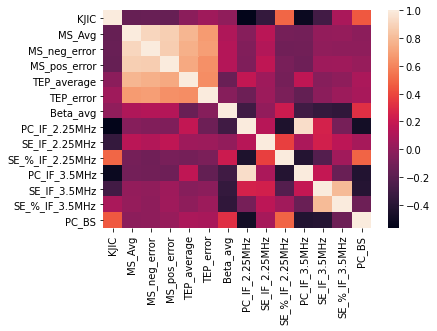

In [113]:
sns.heatmap(merged.corr())

In [172]:
# Seperating data depending on the type of steel
SS_304=scaled_df[0][scaled_df[0].index.isin(['304-0','304-20','304-40','304-60','304-80'])]
SS_316=scaled_df[0][scaled_df[0].index.isin(['316-0','316-20','316-40','316-60','316-80'])]
SS_347=scaled_df[0][scaled_df[0].index.isin(['347-0','347-20','347-40','347-60','347-80'])]
SS_A286=scaled_df[0][scaled_df[0].index.isin(['A286-0','A286-20','A286-40','A286-60','A286-80'])]

In [176]:
SS_list=["SS304","SS316","SS347","SSA286"]

## Linear Regression

In [177]:
def lr_sstype(scaled_df,name):
    # Creating Predictor variable 'X' and Target Variable 'y'
    # X contains all the features except for the target value Price
    X = scaled_df.drop('KJIC', axis = 1)
    y = scaled_df['KJIC']
    
    # Creating the training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=50)
    
    # X_train contains 70% of total dataset
    print("Training dataset:", X_train.shape)
    # X_test contains 30% of total dataset
    print("Test dataset:", X_test.shape)
    
    # Model Liner Regression
    lr = LinearRegression()
    
    #Train/fit the model to training data
    lr.fit(X_train,y_train)
    
    pred = lr.predict(X_test)
    
    # print the intercept
    print("Intercept:", lr.intercept_)
    
    #Coefficients
    coeff_df = pd.DataFrame(lr.coef_,X.columns,columns=['Coefficient'])
    print("Coefficients:", coeff_df)
    
    
    print("r2 score for training: ", r2_score(y_train, lr.predict(X_train)))
    print("r2 score for testing: ", r2_score(y_test, pred))
    
    print('MAE:', metrics.mean_absolute_error(y_test, pred))
    print('MSE:', metrics.mean_squared_error(y_test, pred))
    print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, pred)))
    
    plt.scatter(y_test,pred)
    plt.title("Linear Regression of "+ name)
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    
    return

Training dataset: (186, 13)
Test dataset: (81, 13)
Intercept: 0.8619188577484572
Coefficients:                  Coefficient
MS_Avg             -0.047660
MS_neg_error       -0.024413
MS_pos_error       -0.046142
TEP_average        -0.331781
TEP_error           0.108148
Beta_avg            0.114581
PC_IF_2.25MHz      -0.297923
SE_IF_2.25MHz      -0.122998
SE_%_IF_2.25MHz     0.224939
PC_IF_3.5MHz       -0.539155
SE_IF_3.5MHz       -0.134697
SE_%_IF_3.5MHz      0.071290
PC_BS              -0.068372
r2 score for training:  0.8004471788497427
r2 score for testing:  0.7689040121377907
MAE: 0.05438934382902115
MSE: 0.004866260121603767
RMSE: 0.06975858457282348


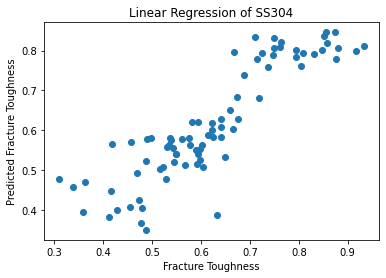

In [175]:
lr_sstype(SS_304,"SS304")

## Ridge Regression

In [178]:
def rr_sstype(scaled_df,name):
    # Creating Predictor variable 'X' and Target Variable 'y'
    # X contains all the features except for the target value Price
    X = scaled_df.drop('KJIC', axis = 1)
    y = scaled_df['KJIC']
    
    # Creating the training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=50)
    
    # X_train contains 70% of total dataset
    print("Training dataset:", X_train.shape)
    # X_test contains 30% of total dataset
    print("Test dataset:", X_test.shape)
    
    #Model Ridge Rigression
    rr = Ridge(alpha=0.01)
    rr.fit(X_train, y_train) 
    pred_train_rr= rr.predict(X_train)
    print("RMSE train:", np.sqrt(mean_squared_error(y_train,pred_train_rr)))
    print("r2 score for training: ", r2_score(y_train, pred_train_rr))
    
    pred_test_rr= rr.predict(X_test)
    print("RMSE test:", np.sqrt(mean_squared_error(y_test,pred_test_rr))) 
    print("r2 score for test: ", r2_score(y_test, pred_test_rr))
    
    plt.scatter(y_test,pred_test_rr)
    plt.title("Ridge Regression of "+ name)
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    
    return

Training dataset: (186, 13)
Test dataset: (81, 13)
RMSE train: 0.06339962762067418
r2 score for training:  0.8003714521463458
RMSE test: 0.06868331366360267
r2 score for test:  0.7759734116798568


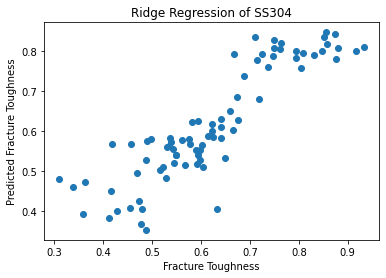

In [185]:
rr_sstype(SS_304,"SS304")

Training dataset: (174, 13)
Test dataset: (75, 13)
RMSE train: 0.07717823036590547
r2 score for training:  0.5438009931379937
RMSE test: 0.08634659514671424
r2 score for test:  0.6285596320492376


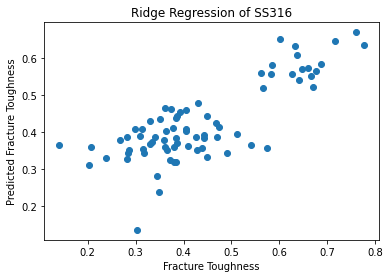

In [186]:
rr_sstype(SS_316,"SS316")

Training dataset: (179, 13)
Test dataset: (78, 13)
RMSE train: 0.0668747099312975
r2 score for training:  0.8916362567375332
RMSE test: 0.08069544177838821
r2 score for test:  0.844269074637611


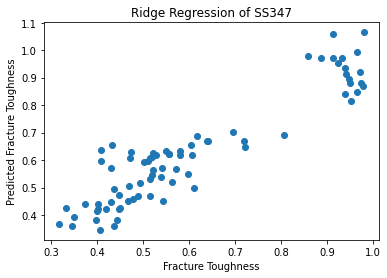

In [187]:
rr_sstype(SS_347,"SS347")

## Elastic net

In [181]:
def enet_sstype(scaled_df,name):
    # Creating Predictor variable 'X' and Target Variable 'y'
    # X contains all the features except for the target value Price
    X = scaled_df.drop('KJIC', axis = 1)
    y = scaled_df['KJIC']
    
    # Creating the training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=50)
    
    # X_train contains 70% of total dataset
    print("Training dataset:", X_train.shape)
    # X_test contains 30% of total dataset
    print("Test dataset:", X_test.shape)
    
    #Model Ridge Rigression
    model_enet = ElasticNet(alpha = 0.01)
    model_enet.fit(X_train, y_train) 
    pred_train_enet= model_enet.predict(X_train)
    print("RMSE train:", np.sqrt(mean_squared_error(y_train,pred_train_enet)))
    print("r2 score for training: ", r2_score(y_train, pred_train_enet))
    
    pred_test_enet= model_enet.predict(X_test)
    print("RMSE test:", np.sqrt(mean_squared_error(y_test,pred_test_enet)))
    print("r2 score for test: ", r2_score(y_test, pred_test_enet))
    
    plt.scatter(y_test,pred_test_enet)
    plt.title("Elastic Net Regression of "+ name)
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    
    return

Training dataset: (186, 13)
Test dataset: (81, 13)
RMSE train: 0.08276055250359264
r2 score for training:  0.6598300108497108
RMSE test: 0.08270719912764325
r2 score for test:  0.6751493702461696


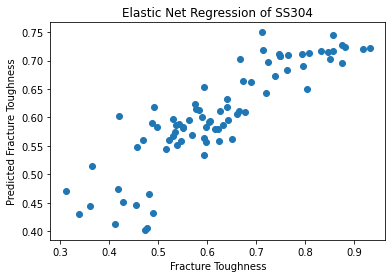

In [182]:
enet_sstype(SS_304,"SS304")

Training dataset: (174, 13)
Test dataset: (75, 13)
RMSE train: 0.1086842924256647
r2 score for training:  0.09531317140418183
RMSE test: 0.13772374216802152
r2 score for test:  0.05503375322399373


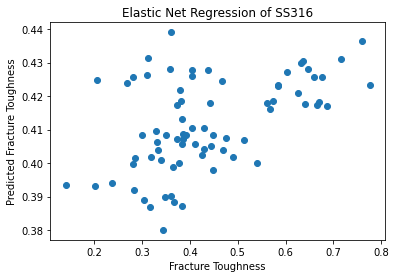

In [188]:
enet_sstype(SS_316,"SS316")

Training dataset: (179, 13)
Test dataset: (78, 13)
RMSE train: 0.09070812285358068
r2 score for training:  0.8006333390293034
RMSE test: 0.09814804445727092
r2 score for test:  0.7696224480492305


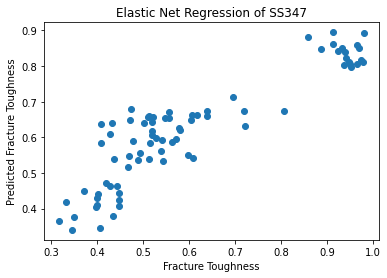

In [190]:
enet_sstype(SS_347,"SS347")

## Lasso 

In [194]:
def lasso_sstype(scaled_df,name):
    # Creating Predictor variable 'X' and Target Variable 'y'
    # X contains all the features except for the target value Price
    X = scaled_df.drop('KJIC', axis = 1)
    y = scaled_df['KJIC']
    
    # Creating the training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=50)
    
    # X_train contains 70% of total dataset
    print("Training dataset:", X_train.shape)
    # X_test contains 30% of total dataset
    print("Test dataset:", X_test.shape)
    
    #Model LASSO Rigression
    model_lasso = Lasso(alpha=0.01)
    model_lasso.fit(X_train, y_train) 
    pred_train_lasso= model_lasso.predict(X_train)
    print("RMSE train:", np.sqrt(mean_squared_error(y_train,pred_train_lasso)))
    print("r2 score for train: ", r2_score(y_train, pred_train_lasso))
    
    pred_test_lasso= model_lasso.predict(X_test)
    print("RMSE test:", np.sqrt(mean_squared_error(y_test,pred_test_lasso))) 
    print("r2 score for test: ", r2_score(y_test, pred_test_lasso))
    
    plt.scatter(y_test,pred_test_lasso)
    plt.title("LASSO Regression of "+ name)
    plt.xlabel("Fracture Toughness")
    plt.ylabel("Predicted Fracture Toughness")
    
    return

Training dataset: (186, 13)
Test dataset: (81, 13)
RMSE train: 0.09311464967246647
r2 score for train:  0.5693888601043547
RMSE test: 0.0945366420013088
r2 score for test:  0.5755784478929111


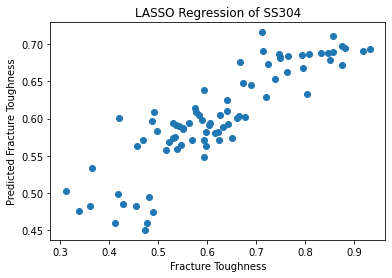

In [195]:
lasso_sstype(SS_304,"SS304")

Training dataset: (174, 13)
Test dataset: (75, 13)
RMSE train: 0.11426616414427013
r2 score for train:  0.0
RMSE test: 0.1445390465608348
r2 score for test:  -0.04080420494733561


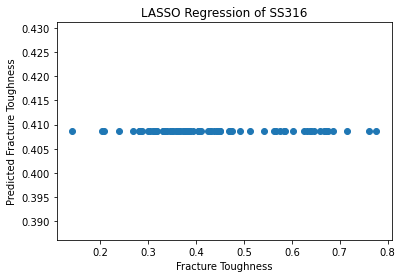

In [196]:
lasso_sstype(SS_316,"SS316")

Training dataset: (179, 13)
Test dataset: (78, 13)
RMSE train: 0.11350965263481344
r2 score for train:  0.6878051278872657
RMSE test: 0.11772015738590262
r2 score for test:  0.668580143262604


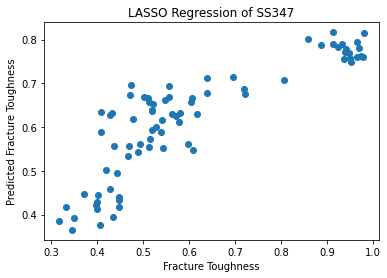

In [197]:
lasso_sstype(SS_347,"SS347")